# Ice Hockey Game Attendance Prediction

## 1. Introduction

In this task, we will be working with a professional ice hockey team's home game data for the past seven seasons. On the basis of this data, the goal of this task is to develop a reliable framework which is capable of predicting attendance for the upcoming season's home games and placing them into tiers. The framework is basically composed of below parts: feature preprocessing, feature engineering, model building, hyperparameter tuning, model evaluation, feature importance, and attendance prediction.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import lightgbm as lgb
from bayes_opt import BayesianOptimization 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.inspection import permutation_importance

## 2. Feature Preprocessing and Feature Engineering
First, we add another two new columns, `Year` and `Month`, which are created from the column, `Date`. Next, with an additional data including each team's official name and its corresponding division, we add a new column, `Division`, and clean the column, `Opponent`, by calculating cosine similarity since there are several typos or extra spaces, which would cause the number of levels of this categorical feature to be incorrect.

After that, since our main goal is to predict attendance for the upcoming season's home games, we only select a subset of the given data which does not contain any preseason game and any home game in the 20-21 season. Then, we check the data type of each column and encode several columns, including `Day of the Week`, `Puck Drop`, `Opponent`, and `Division`, whose data types are object. Besides, we convert the data types of the columns into category.

In [2]:
# load the data
df = pd.read_excel('Questions & Data.xlsx', sheet_name='Home Games - Past 7 Seasons')

In [3]:
# add two new columns, year and month 
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# clean the column, opponent, and add a new column, division
add_df = pd.read_excel('Additional Data.xlsx', sheet_name='Division')
team_name_list = add_df['Team']
tfidf_vectorizer = TfidfVectorizer()
doc_term_matrix = tfidf_vectorizer.fit_transform(team_name_list).toarray()

team = []
division = []
for i in range(df.shape[0]):
    team_name = df['Opponent'][i]
    name_transform = tfidf_vectorizer.transform([team_name]).toarray()
    cosine = cosine_similarity(doc_term_matrix, name_transform)
    index = np.argmax(cosine)
    team.append(add_df['Team'][index])
    division.append(add_df['Division'][index])
df['Team'] = team
df['Division'] = division

In [4]:
# split the data
history_data = df[(df['Season'] != '20-21') & (df['Season'] != '21-22') &
                  (df['Preseason (P)'] != 'P')].reset_index(drop=True)
future_data = df[df['Season'] == '21-22'].reset_index(drop=True)

In [5]:
# feature encoding and data type conversion
for data in [history_data, future_data]:
    for feature in ['Day of the Week', 'Puck Drop', 'Team', 'Division']:
        le = preprocessing.LabelEncoder()
        le.fit(data[feature])
        encoded_label = le.transform(data[feature])
        data[feature] = pd.DataFrame(encoded_label)
        data[feature] = data[feature].astype("category")      

## 3. Model Building and Hyperparameter Tuning
After feature preprocessing and feature engineering, we define two important functions to assist us in building a regression or classification model and tuning its hyperparameters. In this task, we will apply three different models on the given data, **k-nearest neighbors**, **random forest**, and [**LightGBM**](https://lightgbm.readthedocs.io/en/latest/), a gradient boosting framework that uses tree-based learning algorithms. Next, regarding hyperparameter tuning, we choose to use [**Bayesian Optimization**](https://github.com/fmfn/BayesianOptimization) with 5-fold cross validation instead of grid search or random search since Bayesian Optimization is far more efficient in saving time and has better overall performance.

In [6]:
# define a function to tune parameters using baysian optimization
def bayes_tuning(X_train, y_train, model_name, model_goal, init_round=25, opt_round=20, random_state=42):
    
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    if model_goal == 'classification':
        info = c_model_info
    elif model_goal == 'regression':
        info = r_model_info
    model = info[model_name][0]
    given_params = info[model_name][1]
    tuned_params = info[model_name][2]
    
    def cal_function(**fields):
        MAX_MIN_FIELDS = ['learning_rate']
        INT_ROUND_FIELD = ['n_neighbors',
                           'max_depth',
                           'min_samples_leaf',
                           'min_samples_split',
                           'n_estimators',
                           'num_leaves',
                           'min_child_samples']     
        for (key, value) in fields.items():
            if key in MAX_MIN_FIELDS:
                given_params[key] = max(min(value, 1), 0)
            elif key in INT_ROUND_FIELD:
                given_params[key] = int(round(value))
        return predict(given_params)
    
    def predict(params):
        rm = model
        rm.set_params(**params)
        #rm.fit(X_train, y_train)
        #y_pred = rm.predict(X_test)
        if model_goal == 'classification':
            # metric = precision_score(y_pred, y_test, average='micro')
            cv = cross_val_score(rm, X_train, y_train, cv=5, scoring='accuracy')
            metric = np.mean(cv)
        elif model_goal == 'regression':
            # metric = mean_squared_error(y_test, y_pred)*(-1)
            cv = cross_val_score(rm, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
            metric = np.mean(cv)
        return metric
    
    BO = BayesianOptimization(cal_function, tuned_params, random_state=42)       
    BO.maximize(init_points=init_round, n_iter=opt_round)
    model_mse = []
    for model in range(len(BO.res)):
        model_mse.append(BO.res[model]['target'])
        
    return BO.res[pd.Series(model_mse).idxmax()]['target'], BO.res[pd.Series(model_mse).idxmax()]['params']

In [7]:
# define a function to fit the data with the optimal parameters
def model_fitting(X, y, model_name, model_goal, optimal_params):
    
    if model_goal == 'classification':
        info = c_model_info
    elif model_goal == 'regression':
        info = r_model_info
    model = info[model_name][0]
    given_params = info[model_name][1]
    
    for param in optimal_params[1].keys():
        if param == 'learning_rate':
            optimal_params[1][param] = round(optimal_params[1][param], 2)
        else:
            optimal_params[1][param] = int(round(optimal_params[1][param]))
    given_params.update(optimal_params[1])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)    
    rm = model
    rm.set_params(**given_params)
    rm.fit(X_train, y_train)
    y_pred = rm.predict(X_test)
    
    if model_goal == 'classification':
        accuracy = precision_score(y_pred, y_test, average='micro')
        cf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
        output = [rm, round(accuracy, 2), cf_matrix]
    elif model_goal == 'regression':
        mse = mean_squared_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        output = [rm, round(mse, 2), round(100*mape, 2)]
    
    return output

## 4. Model Evaluation
### 4.1 Overview
After defining two functions for model building and hyperparameter tuning, we then check the distribution of our response, `Attendance`. It is worth noting that the full capacity of our home stadium for hockey is 18,532. As shown in the below figures, the number of games at full capacity is actually about half of the total number of games, which indicates there is a potential imbalanced problem. 

If there is an imbalanced problem for regression, it's usual to perform a data transformation or a over-sampling technique such as SMOGN (Synthetic Minority Over-Sampling Technique for Regression with Gaussian Noise). Instead, since about half of games are at full capacity, we are going to propose a two-layer model to solve the problem in the section 4.3. In short, we first use a classification model to classify whether or not a given game is at full capacity. If it is at full capacity, its predicted attendance would directly equal to 18,532. If it is not at full capacity, we then use a regression model to predict its attendance.

In order to verify whether the proposed two-layer model is appropriate, we also propose a one-layer model in the section 4.2. Without performing any data transformation or over-sampling techniques, we directly use a regression model to predict attendance. Next, regarding feature selection, as a sports fan, I basically decide whether to attend a game on the basis of several available information before the game starts. Therfore, on the basis of the given data, we select `Day of the Week`, `Puck Drop`, `Team`, `Division`, and `Month` as our model features (i.e., predictors).

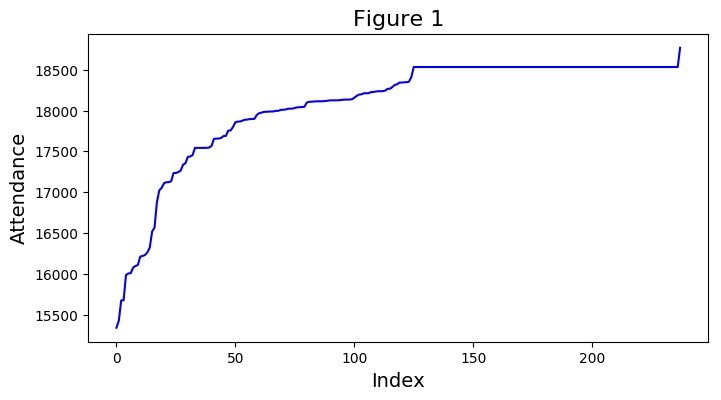

In [8]:
# attendance distribution (1)
plt.style.use('default')
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(history_data.shape[0]), np.sort(history_data['Attendance']), color='blue')
ax.set_title('Figure 1', fontsize=16)
ax.set_xlabel('Index', fontsize=14)
ax.set_ylabel('Attendance', fontsize=14)
plt.show()

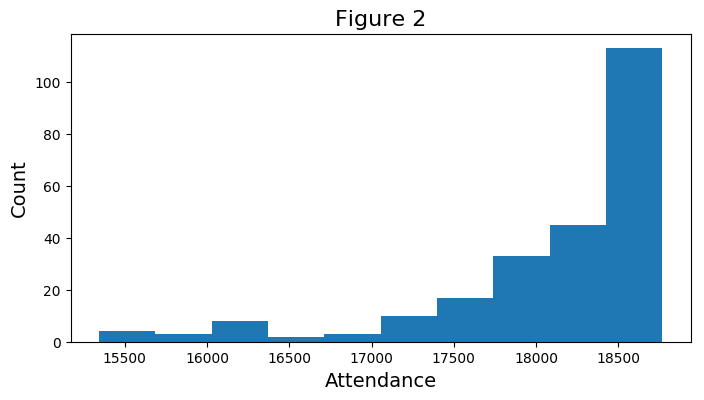

In [9]:
# attendance distribution (2)
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(history_data['Attendance'])
ax.set_title('Figure 2', fontsize=16)
ax.set_xlabel('Attendance', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
plt.show()

### 4.2 One-Layer Model
As mentioned is the section 4.1, the one-layer model represents that we use a regression model to predict attendance without any data transformation or over-sampling techniques. Therefore, in this section, we are able to use the two defined functions in the section 3 to train three regression models, including k-nearest neighbors, random forest, and LightGBM, separately. After that, we evaluate their performances using **test MSE** (Mean Squared Error ) and **test MAPE** (Mean Absolute Percentage Error).

As shown in the below table, the LightGBM regressor outperforms the k-nearest neighbors regressor and the random forest regressor on both test MSE and test MAPE. Furthermore, we check the distributions of the true attendance and the preidicted attendance of the three regressors. As shown in the below figures, it's obvious that the three regressors are all largely affected by the high number of games whose attendance is equal to 18,532.

In [10]:
# model inoformation
r_model_info = {'knn': [KNeighborsRegressor(),
                        {'weights':'distance'},
                        {'n_neighbors':(1,20)}],
                'rf': [RandomForestRegressor(),
                       {'criterion':'mse', 'max_features':'auto'},
                       {'max_depth':(10,50), 'min_samples_leaf':(2,5),
                        'min_samples_split':(2,5), 'n_estimators':(100,500)}],
                'lightgbm': [lgb.LGBMRegressor(),
                             {'boosting_type':'gbdt'},
                             {'learning_rate':(0.01,1.0), 'num_leaves':(30,200),
                              'max_depth':(1,30), 'min_child_samples':(20,80)}]}
c_model_info = {'knn': [KNeighborsClassifier(),
                        {'weights':'distance'},
                        {'n_neighbors':(1,20)}],
                'rf': [RandomForestClassifier(),
                       {'max_features':'auto'},
                       {'max_depth':(10,50), 'min_samples_leaf':(2,5),
                        'min_samples_split':(2,5), 'n_estimators':(100,500)}],
                'lightgbm': [lgb.LGBMClassifier(),
                             {'boosting_type':'gbdt', 'objective':'binary'},
                             {'learning_rate':(0.01,1.0), 'num_leaves':(30,200),
                              'max_depth':(1,30), 'min_child_samples':(20,80)}]}

In [11]:
# regression model training
features = ['Day of the Week', 'Puck Drop', 'Team', 'Division', 'Month']
X = history_data[features].to_numpy()
y = history_data[['Attendance']].to_numpy().ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

knnr_optimal_params = bayes_tuning(X_train, y_train, 'knn', 'regression')
knnr_results = model_fitting(X, y, 'knn', 'regression', knnr_optimal_params)
rfr_optimal_params = bayes_tuning(X_train, y_train, 'rf', 'regression')
rfr_results = model_fitting(X, y, 'rf', 'regression', rfr_optimal_params)
lgbr_optimal_params = bayes_tuning(X_train, y_train, 'lightgbm', 'regression')
lgbr_results = model_fitting(X, y, 'lightgbm', 'regression', lgbr_optimal_params)

|   iter    |  target   | n_neig... |
-------------------------------------
|  1        | -5.788e+0 |  8.116    |
|  2        | -5.491e+0 |  19.06    |
|  3        | -5.563e+0 |  14.91    |
|  4        | -5.64e+05 |  12.37    |
|  5        | -6.212e+0 |  3.964    |
|  6        | -6.212e+0 |  3.964    |
|  7        | -6.858e+0 |  2.104    |
|  8        | -5.532e+0 |  17.46    |
|  9        | -5.64e+05 |  12.42    |
|  10       | -5.614e+0 |  14.45    |
|  11       | -8.242e+0 |  1.391    |
|  12       | -5.491e+0 |  19.43    |
|  13       | -5.532e+0 |  16.82    |
|  14       | -5.992e+0 |  5.034    |
|  15       | -6.212e+0 |  4.455    |
|  16       | -6.212e+0 |  4.485    |
|  17       | -5.776e+0 |  6.781    |
|  18       | -5.68e+05 |  10.97    |
|  19       | -5.701e+0 |  9.207    |
|  20       | -5.776e+0 |  6.533    |
|  21       | -5.593e+0 |  12.63    |
|  22       | -6.212e+0 |  3.65     |
|  23       | -5.776e+0 |  6.551    |
|  24       | -5.788e+0 |  7.961    |
|  25       

|  44       | -4.959e+0 |  24.93    |  2.951    |  3.628    |  340.1    |
|  45       | -4.705e+0 |  47.39    |  4.654    |  4.43     |  467.0    |
|   iter    |  target   | learni... | max_depth | min_ch... | num_le... |
-------------------------------------------------------------------------
|  1        | -4.677e+0 |  0.3808   |  28.57    |  63.92    |  131.8    |
|  2        | -5.027e+0 |  0.1645   |  5.524    |  23.49    |  177.2    |
|  3        | -5.966e+0 |  0.6051   |  21.53    |  21.24    |  194.9    |
|  4        | -5.592e+0 |  0.8341   |  7.158    |  30.91    |  61.18    |
|  5        | -4.374e+0 |  0.3112   |  16.22    |  45.92    |  79.51    |
|  6        | -4.758e+0 |  0.6157   |  5.045    |  37.53    |  92.28    |
|  7        | -5.031e+0 |  0.4615   |  23.77    |  31.98    |  117.4    |
|  8        | -4.524e+0 |  0.5965   |  2.347    |  56.45    |  58.99    |
|  9        | -4.718e+0 |  0.0744   |  28.52    |  77.94    |  167.4    |
|  10       | -4.543e+0 |  0.3116   | 

In [12]:
# test mse and test mape
model_names = ['K-Nearest Neighbors', 'Random Forest', 'LightGBM']
m1 = {'MSE': [knnr_results[1], rfr_results[1], lgbr_results[1]],
      'MAPE (%)': [knnr_results[2], rfr_results[2], lgbr_results[2]]}
metric_df = pd.DataFrame(data=m1, index=model_names)
metric_df

,MSE,MAPE (%)
K-Nearest Neighbors,526732.59,2.86
Random Forest,481752.00,2.72
LightGBM,481315.11,2.58


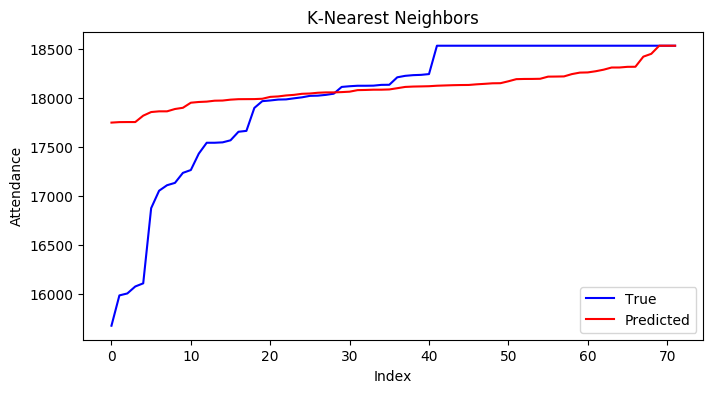

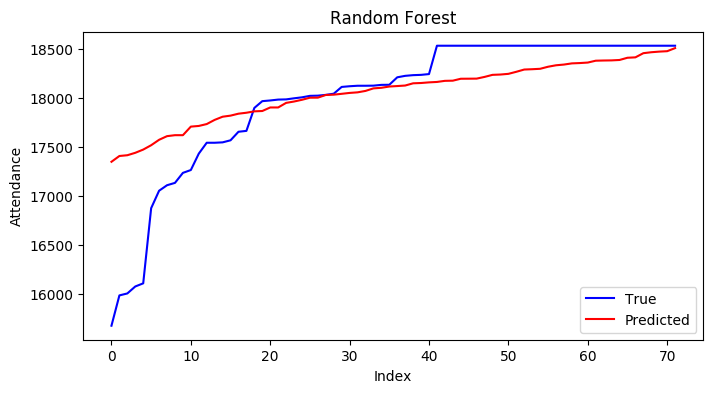

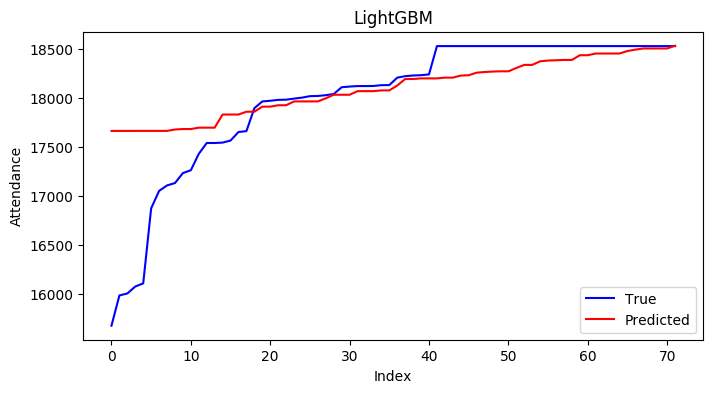

In [13]:
# true value and predicted value
preds = [knnr_results[0].predict(X_test), rfr_results[0].predict(X_test), lgbr_results[0].predict(X_test)]
for i in range(len(preds)):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(range(len(y_test)), np.sort(y_test), color='blue')
    ax.plot(range(len(y_test)), np.sort(preds[i]), color='red')
    ax.set_title(model_names[i])
    ax.set_xlabel('Index')
    ax.set_ylabel('Attendance')    
    line = [Line2D([0], [0], color=c, linewidth=1.5) for c in ['blue', 'red']]
    label = ['True', 'Predicted']
    plt.legend(line, label, loc=4)
    plt.show()

### 4.3 Two-Layer Model
As mentioned in the section 4.1, the number of games at full capacity is actually about half of the total number of games, which indicates there is a potential imbalanced problem. In order to solve the problem, we propose a two-layer model in this section. In short, we first use a classification model to classify whether or not a given game is at full capacity. If it is at full capacity, its predicted attendance would directly equal to 18,532. If it is not at full capacity, we then use a regression model to predict its attendance.

In the first layer, we use the two defined functions in the section 3 to train three classification models, including k-nearest neighbors, random forest, and LightGBM, separately. Then, we evaluate their performances using **test accuracy** and **confusion matrix**. As shown in the first three figures, the random forest classifier outperforms the k-nearest neighbors classifier and the LightGBM classifier on test accuracy. The test accuracy is about 70% and the confusion matrix verifies there is no significant class imbalanced problem, which indicates the random forest classifier is acceptable in the first layer. 

Next, in the second layer, we use the two defined functions again to train three regression models, also including k-nearest neighbors, random forest, and LightGBM, separately. Then, we evaluate their performances using **test MSE** (Mean Squared Error ) and **test MAPE** (Mean Absolute Percentage Error). As shown in the first table, the k-nearest neighbors regressor outperforms the LightGBM regressor and the random forest regressor on both test MSE and test MAPE. Therefore, we decide to use the k-nearest neighbors regressor in the second layer.

Finally, we combine the random forest classifier and the k-nearest neighbors regressor into our two-layer model. Then, we evaluate its performance using **test MSE** (Mean Squared Error ) and **test MAPE** (Mean Absolute Percentage Error). In order to verify whether the two-layer model is more appropriate than the one-layer models in the section 4.2, we use the same test data as in the section 4.2. As shown in the second table, the two-layer model outperforms all the one-layer models on both test MSE and test MAPE. Also, we check the distribution of the true attendance and the preidicted attendance of the two-layer model. As shown in the last figure, unlike the one-layer models, the distribution of the preidicted attendance is pretty similar to the distribution of the true attendance, which indicates the two-layer model is pretty decent and more appropriate than all the one-layer models in the section 4.2.

In [14]:
# add a new column, full or not
history_data['Full or Not'] = [1 if x >= 18532 else 0 for x in history_data['Attendance']]
history_data['Full or Not'] = history_data['Full or Not'].astype("category")

In [15]:
# classification model training (layer 1)
features = ['Day of the Week', 'Puck Drop', 'Team', 'Division', 'Month']
X = history_data[features].to_numpy()
y = history_data[['Full or Not']].to_numpy().ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

knnc_optimal_params = bayes_tuning(X_train, y_train, 'knn', 'classification')
knnc_results = model_fitting(X, y, 'knn', 'classification', knnc_optimal_params)
rfc_optimal_params = bayes_tuning(X_train, y_train, 'rf', 'classification')
rfc_results = model_fitting(X, y, 'rf', 'classification', rfc_optimal_params)
lgbc_optimal_params = bayes_tuning(X_train, y_train, 'lightgbm', 'classification')
lgbc_results = model_fitting(X, y, 'lightgbm', 'classification', lgbc_optimal_params)

|   iter    |  target   | n_neig... |
-------------------------------------
|  1        |  0.5729   |  8.116    |
|  2        |  0.5971   |  19.06    |
|  3        |  0.5727   |  14.91    |
|  4        |  0.5545   |  12.37    |
|  5        |  0.5544   |  3.964    |
|  6        |  0.5544   |  3.964    |
|  7        |  0.5848   |  2.104    |
|  8        |  0.603    |  17.46    |
|  9        |  0.5545   |  12.42    |
|  10       |  0.5667   |  14.45    |
|  11       |  0.5667   |  1.391    |
|  12       |  0.5971   |  19.43    |
|  13       |  0.603    |  16.82    |
|  14       |  0.6027   |  5.034    |
|  15       |  0.5544   |  4.455    |
|  16       |  0.5544   |  4.485    |
|  17       |  0.6091   |  6.781    |
|  18       |  0.5788   |  10.97    |
|  19       |  0.5791   |  9.207    |
|  20       |  0.6091   |  6.533    |
|  21       |  0.5786   |  12.63    |
|  22       |  0.5544   |  3.65     |
|  23       |  0.6091   |  6.551    |
|  24       |  0.5729   |  7.961    |
|  25       

|  43       |  0.6392   |  11.85    |  3.399    |  2.904    |  392.7    |
|  44       |  0.6512   |  23.06    |  4.845    |  2.972    |  214.7    |
|  45       |  0.6574   |  11.8     |  4.376    |  3.733    |  424.7    |
|   iter    |  target   | learni... | max_depth | min_ch... | num_le... |
-------------------------------------------------------------------------
|  1        |  0.5611   |  0.3808   |  28.57    |  63.92    |  131.8    |
|  2        |  0.6512   |  0.1645   |  5.524    |  23.49    |  177.2    |
|  3        |  0.6394   |  0.6051   |  21.53    |  21.24    |  194.9    |
|  4        |  0.6818   |  0.8341   |  7.158    |  30.91    |  61.18    |
|  5        |  0.6934   |  0.3112   |  16.22    |  45.92    |  79.51    |
|  6        |  0.6513   |  0.6157   |  5.045    |  37.53    |  92.28    |
|  7        |  0.6815   |  0.4615   |  23.77    |  31.98    |  117.4    |
|  8        |  0.6873   |  0.5965   |  2.347    |  56.45    |  58.99    |
|  9        |  0.5061   |  0.0744   | 

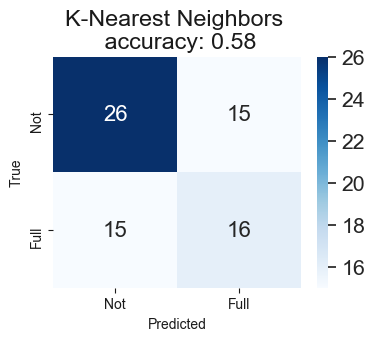

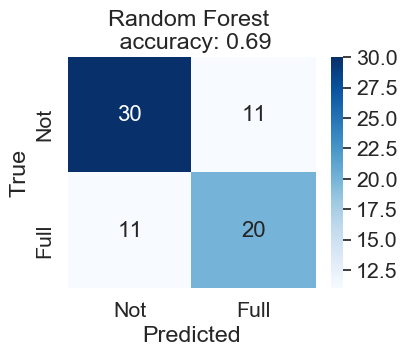

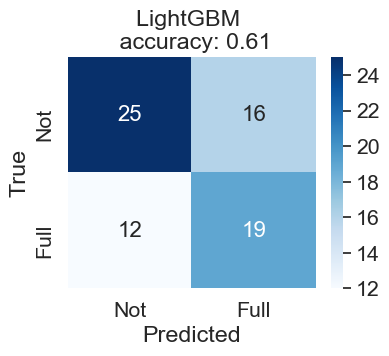

In [16]:
# test accuracy and confusion matrix (layer 1)
results = [knnc_results, rfc_results, lgbc_results]
for i in range(len(results)):
    data = results[i][2]
    df_cm = pd.DataFrame(data, columns=['Not', 'Full'], index=['Not', 'Full'])
    df_cm.index.name = 'True'
    df_cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=(4,3))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, cmap='Blues', annot=True, annot_kws={'size':16}, fmt='g')
    plt.title('{} \n accuracy: {}'.format(model_names[i], round(results[i][1], 3)))
    plt.show()

In [17]:
# regression model training (layer 2)
not_full_data = history_data[history_data['Full or Not'] == 0].reset_index(drop=True)
features = ['Day of the Week', 'Puck Drop', 'Team', 'Division', 'Month']
X = not_full_data[features].to_numpy()
y = not_full_data[['Attendance']].to_numpy().ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

knnr_optimal_params = bayes_tuning(X_train, y_train, 'knn', 'regression')
knnr_results = model_fitting(X, y, 'knn', 'regression', knnr_optimal_params)
rfr_optimal_params = bayes_tuning(X_train, y_train, 'rf', 'regression')
rfr_results = model_fitting(X, y, 'rf', 'regression', rfr_optimal_params)
lgbr_optimal_params = bayes_tuning(X_train, y_train, 'lightgbm', 'regression')
lgbr_results = model_fitting(X, y, 'lightgbm', 'regression', lgbr_optimal_params)

|   iter    |  target   | n_neig... |
-------------------------------------
|  1        | -4.143e+0 |  8.116    |
|  2        | -4.137e+0 |  19.06    |
|  3        | -4.168e+0 |  14.91    |
|  4        | -4.196e+0 |  12.37    |
|  5        | -4.254e+0 |  3.964    |
|  6        | -4.254e+0 |  3.964    |
|  7        | -5.065e+0 |  2.104    |
|  8        | -4.128e+0 |  17.46    |
|  9        | -4.196e+0 |  12.42    |
|  10       | -4.158e+0 |  14.45    |
|  11       | -7.062e+0 |  1.391    |
|  12       | -4.137e+0 |  19.43    |
|  13       | -4.128e+0 |  16.82    |
|  14       | -4.304e+0 |  5.034    |
|  15       | -4.254e+0 |  4.455    |
|  16       | -4.254e+0 |  4.485    |
|  17       | -4.202e+0 |  6.781    |
|  18       | -4.175e+0 |  10.97    |
|  19       | -4.185e+0 |  9.207    |
|  20       | -4.202e+0 |  6.533    |
|  21       | -4.149e+0 |  12.63    |
|  22       | -4.254e+0 |  3.65     |
|  23       | -4.202e+0 |  6.551    |
|  24       | -4.143e+0 |  7.961    |
|  25       

|  43       | -4.237e+0 |  11.99    |  3.169    |  2.773    |  230.7    |
|  44       | -4.146e+0 |  43.66    |  3.195    |  2.861    |  173.4    |
|  45       | -4.293e+0 |  43.71    |  3.568    |  2.916    |  172.3    |
|   iter    |  target   | learni... | max_depth | min_ch... | num_le... |
-------------------------------------------------------------------------
|  1        | -4.287e+0 |  0.3808   |  28.57    |  63.92    |  131.8    |
|  2        | -4.162e+0 |  0.1645   |  5.524    |  23.49    |  177.2    |
|  3        | -4.517e+0 |  0.6051   |  21.53    |  21.24    |  194.9    |
|  4        | -4.419e+0 |  0.8341   |  7.158    |  30.91    |  61.18    |
|  5        | -4.287e+0 |  0.3112   |  16.22    |  45.92    |  79.51    |
|  6        | -4.287e+0 |  0.6157   |  5.045    |  37.53    |  92.28    |
|  7        | -4.541e+0 |  0.4615   |  23.77    |  31.98    |  117.4    |
|  8        | -4.287e+0 |  0.5965   |  2.347    |  56.45    |  58.99    |
|  9        | -4.287e+0 |  0.0744   | 

In [18]:
# test mse and test mape (layer 2)
m2 = {'MSE': [knnr_results[1], rfr_results[1], lgbr_results[1]],
      'MAPE (%)': [knnr_results[2], rfr_results[2], lgbr_results[2]]}
metric_df = pd.DataFrame(data=m2, index=model_names)
metric_df

,MSE,MAPE (%)
K-Nearest Neighbors,871190.79,4.30
Random Forest,937740.27,4.49
LightGBM,935007.08,4.53


In [19]:
# two-layer model performance (1)
features = ['Day of the Week', 'Puck Drop', 'Team', 'Division', 'Month']
X = history_data[features].to_numpy()
yc = history_data[['Full or Not']].to_numpy().ravel()
X_train, X_test, y_train, y_test = train_test_split(X, yc, test_size=0.3, random_state=42)

y_pred_1 = rfc_results[0].predict(X_test)
X_test_2 = X_test[np.where(y_pred_1 == 0)[0]]
y_pred_2 = knnr_results[0].predict(X_test_2)

y_pred = y_pred_1
y_pred[np.where(y_pred == 1)[0]] = 18532
y_pred[np.where(y_pred == 0)[0]] = y_pred_2

yr = history_data[['Attendance']].to_numpy().ravel()
X_train, X_test, y_train, y_test = train_test_split(X, yr, test_size=0.3, random_state=42)
m3 = {'MSE': [round(mean_squared_error(y_test, y_pred),2)],
      'MAPE (%)': [round(100*mean_absolute_percentage_error(y_test, y_pred),2)]}
old_metric_df = pd.DataFrame(data=m1, index=model_names)
metric_df = pd.DataFrame(data=m3, index=['Two-Layer Model'])
final_metric_df = pd.concat([old_metric_df, metric_df])
final_metric_df

,MSE,MAPE (%)
K-Nearest Neighbors,526732.59,2.86
Random Forest,481752.00,2.72
LightGBM,481315.11,2.58
Two-Layer Model,395365.49,1.95


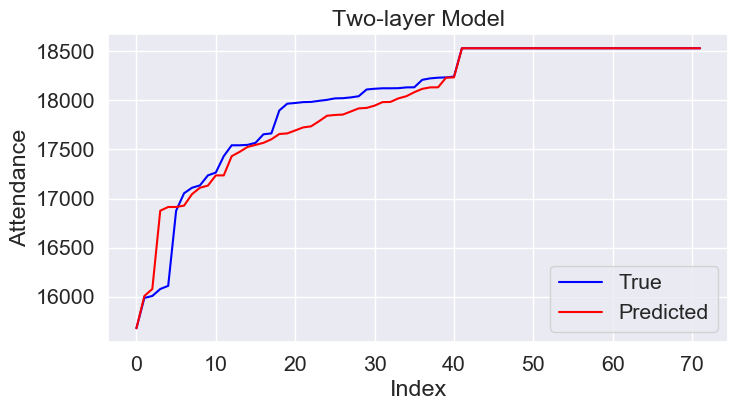

In [20]:
# two-layer model performance (2)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(len(y_test)), np.sort(y_test), color='blue')
ax.plot(range(len(y_test)), np.sort(y_pred), color='red')
ax.set_title('Two-layer Model')
ax.set_xlabel('Index')
ax.set_ylabel('Attendance')    
line = [Line2D([0], [0], color=c, linewidth=1.5) for c in ['blue', 'red']]
label = ['True', 'Predicted']
plt.legend(line, label, loc=4)
plt.show()

## 5. Feature Importance
As mentioned in the section 4.3, we combine the random forest classifier and the k-nearest neighbors regressor into our two-layer model. In the first layer, we use the random forest classifier to classify whether or not a given game is at full capacity. In the second layer, we use the k-nearest neighbors regressor to predict attendance for games which are not at full capacity.

In this section, we are going to figure out which features have significant impact on classifying whether or not a given game is at full capacity and predicting attendance for games which are not at full capacity. As shown in the below figures, no matter for the random forest classifier or the k-nearest neighbors regressor, we could find that `Opponent`, `Day of the Week`, and `Month` are the top three important features, which is pretty reasonable.

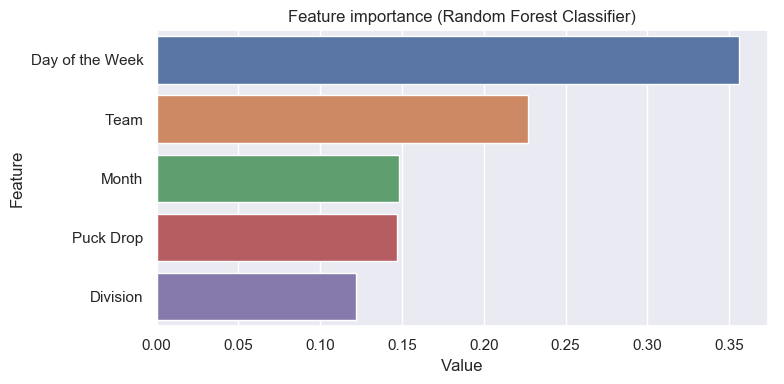

In [21]:
# feature importance (random forest)
feature_imp = pd.DataFrame({'Value': rfc_results[0].feature_importances_, 
                            'Feature': features})
plt.figure(figsize=(8, 4))
sns.set(font_scale = 1)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:13])
plt.title('Feature importance (Random Forest Classifier)')
plt.tight_layout()
plt.show(plt.show)

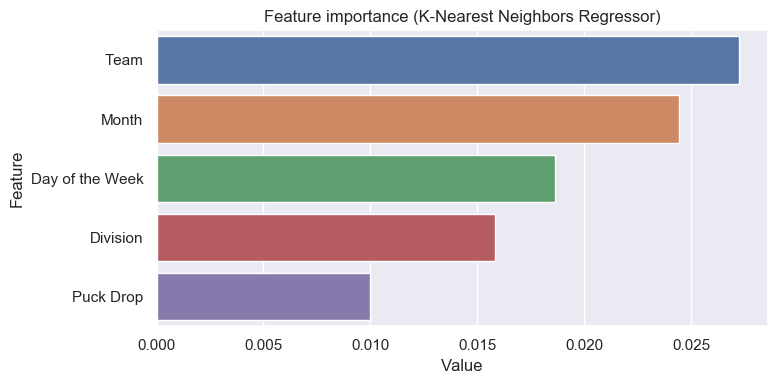

In [22]:
# feature importance (k-nearest neighbors)
not_full_data = history_data[history_data['Full or Not'] == 0].reset_index(drop=True)
X = not_full_data[features].to_numpy()
y = not_full_data[['Attendance']].to_numpy().ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

p_results = permutation_importance(knnr_results[0], X_train, y_train, scoring='neg_mean_absolute_percentage_error')
feature_imp = pd.DataFrame({'Value': p_results.importances_mean, 'Feature': features})
plt.figure(figsize=(8, 4))
sns.set(font_scale = 1)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:13])
plt.title('Feature importance (K-Nearest Neighbors Regressor)')
plt.tight_layout()
plt.show()

## 6. Attendance Prediction for Next Season
Again, the goal of this task is to develop a reliable framework which is capable of predicting attendance for the upcoming season's home games and placing them into tiers. Now, we are able to use the proposed two-layer model to predict attendance for the 21-22 season's home games. Then, we check the distribution of the predicted attendance. As shown in the below figure, there are three groups of the predicted attendance. Therefore, we decide to place the 21-22 season's home games into **three tiers**. The first tier represents the games which are projected to be at full capacity. Next, the second tier represents the games whose attendance is projected to be between 17500 and 18000. Finally, the third tier represents the games whose attendance is projected to be lower than 17500.

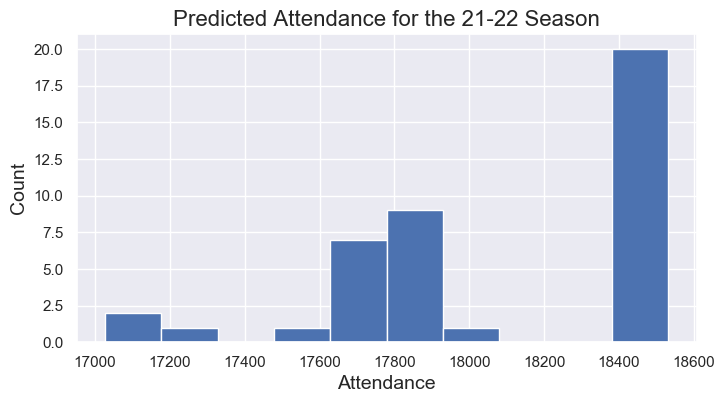

In [23]:
# prediction
future_X_1 = future_data[features].to_numpy()

y_pred_1 = rfc_results[0].predict(future_X_1)
future_X2 = future_X_1[np.where(y_pred_1 == 0)[0]]
y_pred_2 = knnr_results[0].predict(future_X2)

future_y = y_pred_1
future_y[np.where(future_y == 1)[0]] = 18532
future_y[np.where(future_y == 0)[0]] = y_pred_2


fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(future_y)
ax.set_title('Predicted Attendance for the 21-22 Season', fontsize=16)
ax.set_xlabel('Attendance', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
plt.show()